# Part 2: YOLOv11-Seg Training on Dresden Dataset

This notebook trains YOLOv11-Seg for instance segmentation on the Dresden Dataset.

## Group Members

1. Asfar Hossain Sitab (2022-3-60-275)
2. Parmita Hossain Simia (2022-3-60-253)
3. Kamran Hasan (2022-2-60-077)
4. Nusrat Jahan Oishi (2022-2-60-033)

## Data Loading and Setup

Install dependencies and load the dataset.

In [1]:

!pip install --upgrade ultralytics --no-deps

import ultralytics
from ultralytics import YOLO
import os
import yaml

# Assuming dataset is mounted at /kaggle/input/dresden-dataset
dataset_path = '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset' # Corrected dataset path

# Update dataset.yaml paths
data_yaml = {
    'path': dataset_path,
    'train': os.path.join(dataset_path, '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/train'),
    'val': os.path.join(dataset_path, '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/val'),
    'test': os.path.join(dataset_path, '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/test'),
    'nc': 11,
    'names': {
        0: 'abdominal_wall',
        1: 'colon',
        2: 'inferior_mesenteric_artery',
        3: 'intestinal_veins',
        4: 'liver',
        5: 'pancreas',
        6: 'small_intestine',
        7: 'spleen',
        8: 'stomach',
        9: 'ureter',
        10: 'vesicular_glands'
    }
}

# Save updated yaml
with open('data1.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("Dataset setup complete with updated paths.")

data_yaml_path = os.path.join(dataset_path, 'data.yaml')

print("Dataset setup complete with updated paths.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Dataset setup complete with updated paths.
Dataset setup complete with updated paths.


## Sample Visualization with Labels

Visualize sample images from the train set with segmentation masks.

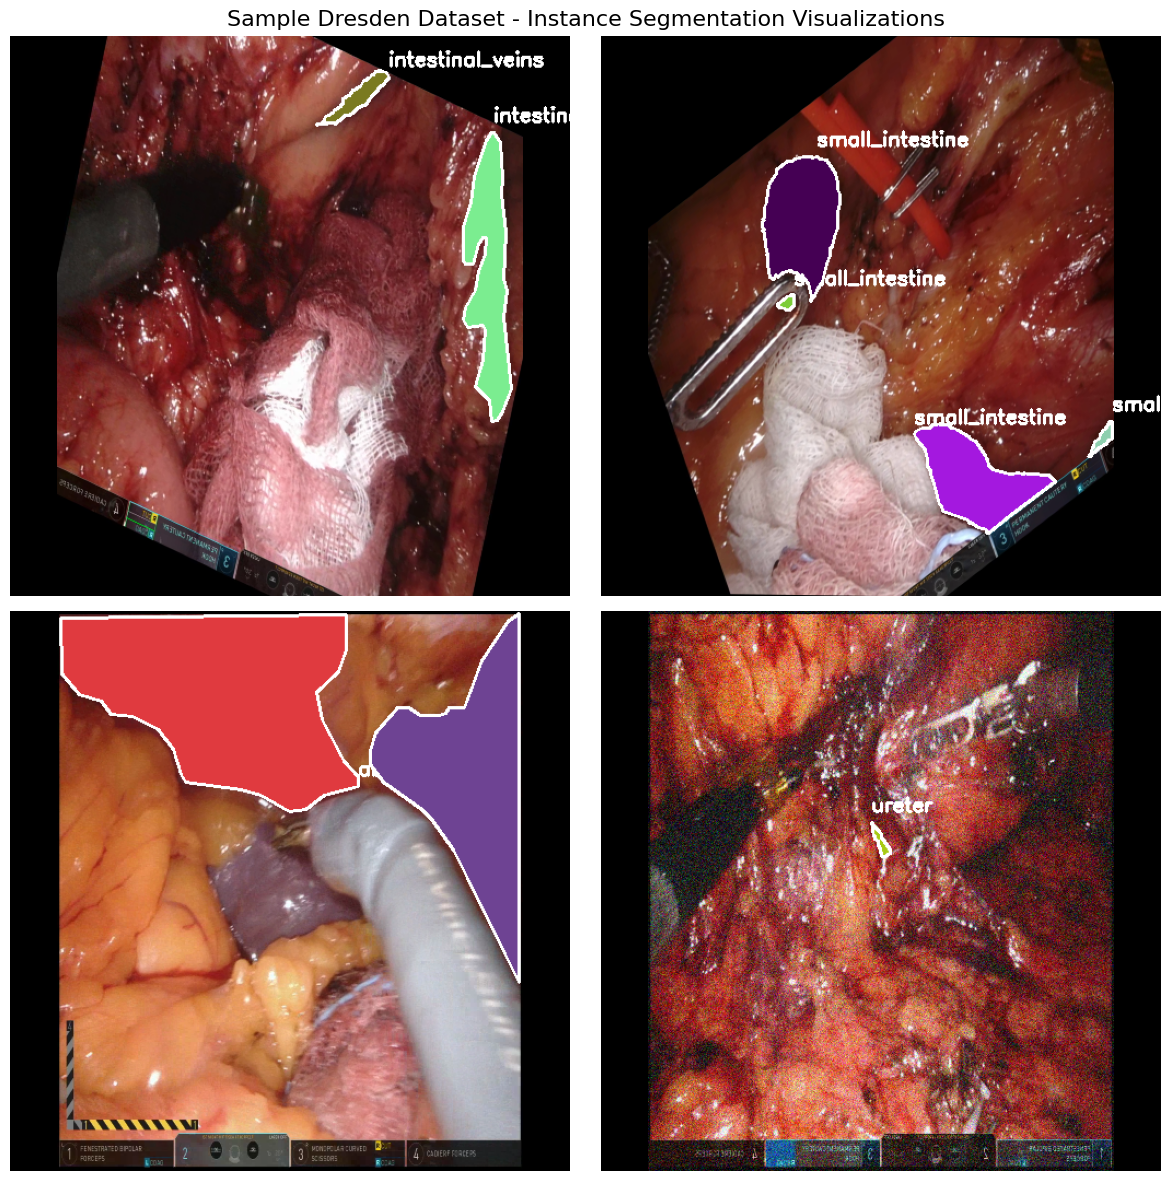

In [2]:
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths
image_dir = os.path.join(dataset_path, "images/train")
label_dir = os.path.join(dataset_path, "labels/train")

# Get random sample of 4 images
image_files = random.sample(os.listdir(image_dir), 4)

def visualize_image(img_path, label_path, class_names=data_yaml['names']):
    """Visualize one image with segmentation masks or bboxes."""
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((100, 100, 3), dtype=np.uint8)

    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            cls_id = int(values[0])
            coords = values[1:]

            # Polygon segmentation
            if len(coords) > 4:
                pts = np.array(coords).reshape(-1, 2)
                pts[:, 0] *= w
                pts[:, 1] *= h
                pts = pts.astype(np.int32)
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.fillPoly(overlay, [pts], color)
                cv2.polylines(overlay, [pts], True, (255,255,255), 2)
                cv2.putText(overlay, f"{class_names[cls_id]}", (pts[0][0], pts[0][1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            else:
                # Bounding box fallback
                xc, yc, bw, bh = coords
                x1, y1 = int((xc - bw / 2) * w), int((yc - bh / 2) * h)
                x2, y2 = int((xc + bw / 2) * w), int((yc + bh / 2) * h)
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
                cv2.putText(overlay, f"{class_names[cls_id]}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return overlay

# Create figure
plt.figure(figsize=(12, 12))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))
    vis = visualize_image(img_path, label_path)

    plt.subplot(2, 2, idx + 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.suptitle("Sample Dresden Dataset - Instance Segmentation Visualizations", fontsize=16)
plt.tight_layout()
plt.show()

## Setup

Point to data.yaml & quick sanity checks.

In [3]:
# Point to data.yaml & quick sanity checks
DATA_YAML = "/kaggle/working/data1.yaml"

# Show the YAML file for quick confirmation
print(open(DATA_YAML).read())

# Optional: basic file count checks (train/val/test)
import yaml
cfg = yaml.safe_load(open(DATA_YAML))
for split in ["train", "val", "test"]:
    if split in cfg and cfg[split]:
        img_dir = cfg[split]
        n = len([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))])
        print(f"{split:<5} -> {img_dir} : {n} files")

names:
  0: abdominal_wall
  1: colon
  2: inferior_mesenteric_artery
  3: intestinal_veins
  4: liver
  5: pancreas
  6: small_intestine
  7: spleen
  8: stomach
  9: ureter
  10: vesicular_glands
nc: 11
path: /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset
test: /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/test
train: /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/train
val: /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/val

train -> /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/train : 17363 files
val   -> /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/val : 5865 files
test  -> /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/images/test : 2952 files


## Model Training

Train YOLOv11-Seg with consistent hyperparameters.

In [4]:
from ultralytics import YOLO

# Load YOLOv11 small segmentation model
model = YOLO('yolo11s-seg.pt')  # correct filename, automatically downloads if missing

# Train the model
results = model.train(
    data=DATA_YAML,        # path to your dataset YAML
    epochs=3,
    imgsz=416,
    batch=2,
    workers=2,
    device=0,              # GPU 0; use 'cpu' for CPU
    patience=10,
    save=True,
    save_period=-1,
    pretrained=True,
    optimizer="auto",
    project="runs",
    name="yolo11_seg_dresden",
    exist_ok=True,
    amp=True               # mixed precision
)

print("Training complete ✅")


Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data1.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_seg_dresden, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5865      10246      0.361      0.366      0.296      0.178      0.371       0.37      0.303       0.17
        abdominal_wall        790       1115      0.327      0.361      0.264      0.171      0.328      0.352      0.259       0.16
                 colon        748       1464      0.334     0.0873      0.151     0.0888      0.335     0.0833      0.153     0.0845
inferior_mesenteric_artery        500        753      0.364      0.251      0.203     0.0859      0.383      0.258      0.215     0.0704
      intestinal_veins        500        767      0.387      0.374      0.295      0.158      0.408      0.387      0.308      0.141
                 liver        556        679      0.742      0.359      0.511      0.327       0.75      0.359      0.506      0.313
              pancreas        575       1488      0.297      0.197      0.162     0.0685       0.31      0.201      0.172     0.0668
       small_intestine        504        918      0.186      0.36

## Loss Curves

Display training and validation loss curves.

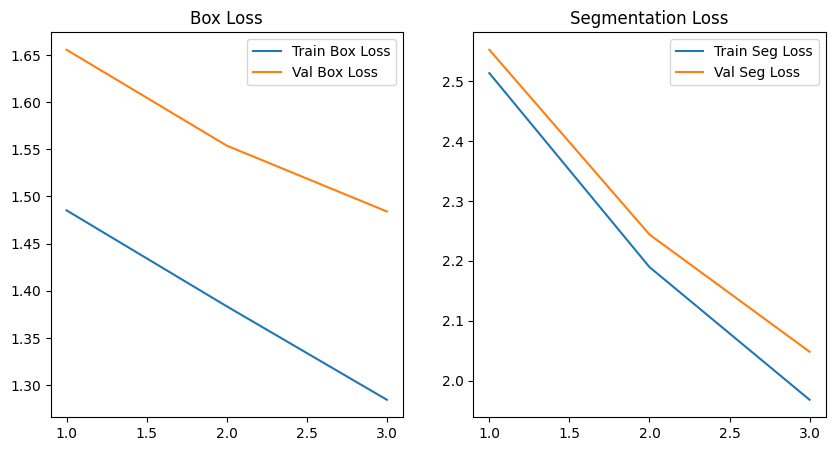

In [5]:
# Display loss curves
import matplotlib.pyplot as plt
import pandas as pd

# Assuming results.csv is saved
results_csv_path = os.path.join(results.save_dir, 'results.csv')
if os.path.exists(results_csv_path):
    df = pd.read_csv(results_csv_path)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
    plt.legend()
    plt.title('Box Loss')
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['train/seg_loss'], label='Train Seg Loss')
    plt.plot(df['epoch'], df['val/seg_loss'], label='Val Seg Loss')
    plt.legend()
    plt.title('Segmentation Loss')
    plt.show()
else:
    print("Results CSV not found.")

## Validation and Results

Validate the model and display results.

In [6]:
# Locate best weights from the run folder
run_dir = results.save_dir if hasattr(results, "save_dir") else "runs/yolov11_seg_dresden"
best_ckpt = os.path.join(run_dir, "weights", "best.pt")
print("Using weights:", best_ckpt)

model = YOLO(best_ckpt)
val_metrics = model.val(split="val")   # uses val set in data.yaml

# The .val() call prints a summary and saves plots (PR curves, confusion, F1, etc.)
# You can also access metrics programmatically:
try:
    # For segmentation: metrics.box.map and metrics.seg.map exist on recent ultralytics
    print("Box  mAP50-95:", getattr(val_metrics.box, "map", None))
    print("Mask mAP50-95:", getattr(val_metrics.seg, "map", None))
except:
    pass

Using weights: /kaggle/working/runs/yolo11_seg_dresden/weights/best.pt
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,071,073 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 386.2±129.9 MB/s, size: 433.0 KB)
val: Scanning /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/labels/val... 5865 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5865/5865 495.2it/s 11.8s
WARNING ⚠️ val: Cache directory /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/labels is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 367/367 5.9it/s 1:02


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5865      10246      0.361      0.366      0.296      0.178      0.371      0.369      0.302      0.169
        abdominal_wall        790       1115      0.328      0.359      0.263      0.171      0.327      0.351      0.259       0.16
                 colon        748       1464      0.333     0.0861      0.151     0.0889      0.336     0.0833      0.153     0.0843
inferior_mesenteric_artery        500        753      0.365      0.252      0.204     0.0857      0.383      0.258      0.213       0.07
      intestinal_veins        500        767      0.389      0.373      0.295      0.159      0.407      0.385      0.307      0.139
                 liver        556        679      0.746      0.359      0.513      0.328      0.753      0.359      0.506      0.313
              pancreas        575       1488      0.297      0.197      0.161     0.0683      0.308      0.201       0.17     0.0659
       small_intestine        504        918      0.187      0.36

## Test Set Evaluation

Evaluate on test split if defined in data.yaml.

In [7]:
# Evaluate on test split if defined in data.yaml
try:
    test_metrics = model.val(split="test")
    try:
        print("Test Box  mAP50-95:", getattr(test_metrics.box, "map", None))
        print("Test Mask mAP50-95:", getattr(test_metrics.seg, "map", None))
    except:
        pass
except Exception as e:
    print("Test evaluation skipped or failed:", e)

Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.5 ms, read: 31.7±5.1 MB/s, size: 320.6 KB)
val: Scanning /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/labels/test... 2952 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2952/2952 125.2it/s 23.6s
WARNING ⚠️ val: Cache directory /kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset/labels is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 185/185 5.7it/s 32.7s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2952       5411       0.34      0.372      0.289      0.167      0.357      0.364       0.29      0.156
        abdominal_wall        434        636      0.437      0.361      0.367      0.243      0.448      0.346      0.364      0.233
                 colon        323        645        0.3     0.0434      0.135     0.0796      0.375     0.0357      0.142     0.0765
inferior_mesenteric_artery        250        354      0.348       0.35      0.277      0.128      0.375      0.348      0.282      0.108
      intestinal_veins        250        318      0.377      0.513      0.376      0.188       0.39      0.497      0.364      0.161
                 liver        329        431       0.53      0.413       0.41      0.271       0.55      0.411      0.407      0.228
              pancreas        264        898      0.398      0.378      0.345      0.173      0.419      0.374      0.346      0.153
       small_intestine        267        448      0.156      0.48

## Prediction & Visualization

Predict & visualize a few samples from the test set.


0: 640x640 1 abdominal_wall, 17.4ms
1: 640x640 1 inferior_mesenteric_artery, 17.4ms
2: 640x640 1 intestinal_veins, 17.4ms
3: 640x640 1 inferior_mesenteric_artery, 17.4ms
Speed: 2.4ms preprocess, 17.4ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)


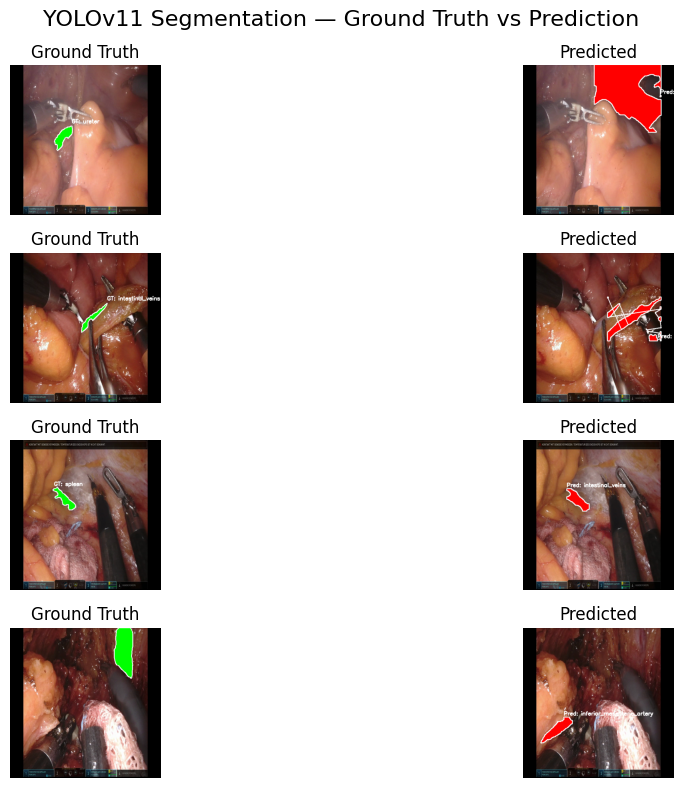

In [8]:
# Predict & visualize a few samples from the test set
import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# Pick a few random test images
test_dir = cfg.get("test")
label_dir = test_dir.replace("/images", "/labels")  # assumes standard YOLO structure

sample_imgs = []
if test_dir and os.path.isdir(test_dir):
    all_imgs = [p for p in glob.glob(os.path.join(test_dir, "*.*"))
                if p.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]
    sample_imgs = random.sample(all_imgs, min(4, len(all_imgs)))

# Helper to draw polygons from YOLO label file (Ground Truth)
def draw_gt_polygons(img_path, label_path, class_names=data_yaml['names']):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                vals = list(map(float, line.strip().split()))
                cls_id = int(vals[0])
                coords = vals[1:]
                if len(coords) > 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    color = (0, 255, 0)  # green for GT
                    cv2.fillPoly(overlay, [pts], color)
                    cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                    label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    cv2.putText(overlay, f"GT: {label}", (pts[0][0], pts[0][1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print(f"⚠️ No label file found for {os.path.basename(img_path)}")

    return overlay

# Helper to draw predicted polygons
def draw_pred_polygons(result):
    img = result.orig_img.copy()

    if getattr(result, "masks", None) is not None and result.masks is not None:
        for i, seg in enumerate(result.masks.xy):
            poly = np.array(seg, dtype=np.int32)
            color = (0, 0, 255)  # red for predictions
            cv2.fillPoly(img, [poly], color)
            cv2.polylines(img, [poly], True, (255, 255, 255), 2)
            if getattr(result, "names", None) is not None and getattr(result.boxes, "cls", None) is not None:
                cls_id = int(result.boxes.cls[i].item())
                label = result.names.get(cls_id, str(cls_id)) if isinstance(result.names, dict) else str(cls_id)
                x, y = poly[0]
                cv2.putText(img, f"Pred: {label}", (int(x), int(y) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print("⚠️ No predicted masks found for:", result.path)

    return img

# Run inference on test set
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, device=0, save=False)

# Plot Predicted vs Ground Truth
plt.figure(figsize=(14, 8))
for i, result in enumerate(preds):
    img_path = result.path
    label_path = os.path.join(label_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    
    # Prepare visualizations
    vis_pred = draw_pred_polygons(result)
    vis_gt = draw_gt_polygons(img_path, label_path)

    vis_pred_rgb = cv2.cvtColor(vis_pred, cv2.COLOR_BGR2RGB)
    vis_gt_rgb = cv2.cvtColor(vis_gt, cv2.COLOR_BGR2RGB)

    # Show side by side
    plt.subplot(len(preds), 2, 2*i + 1)
    plt.imshow(vis_gt_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(len(preds), 2, 2*i + 2)
    plt.imshow(vis_pred_rgb)
    plt.title("Predicted")
    plt.axis("off")

plt.suptitle("YOLOv11 Segmentation — Ground Truth vs Prediction", fontsize=16)
plt.tight_layout()
plt.show()

## Performance Summary

Summary of YOLOv11-Seg performance.

In [9]:
# Create a simple table
performance = {
    'Model': ['YOLOv11-Seg'],
    'Box mAP50-95': [getattr(val_metrics.box, "map", None)],
    'Mask mAP50-95': [getattr(val_metrics.seg, "map", None)]
}

import pandas as pd
df_perf = pd.DataFrame(performance)
print(df_perf)

         Model  Box mAP50-95  Mask mAP50-95
0  YOLOv11-Seg      0.178137       0.169281
